In [52]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [53]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=5927372ba72bb92cddc769f3469339570774c88cd24a0800599f1c303866140a
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [54]:
FOLDS = 10
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
NON_FEATURES = set(TARGET) | {'pid', 'week_last_1', 'week_last_2', 'week_last_3'}
CATEGORICALS = {'sex', 'smoking'}
SCORING = 'neg_root_mean_squared_error'

In [55]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [56]:
train = pd.read_parquet(f'{DATA}/cvtrain.parquet')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pid                    174 non-null    object 
 1   age                    174 non-null    uint8  
 2   sex                    174 non-null    object 
 3   smoking                174 non-null    object 
 4   week_1                 174 non-null    int16  
 5   fvc_1                  174 non-null    uint16 
 6   percent_1              174 non-null    float32
 7   fvc_last_1             174 non-null    uint16 
 8   fvc_last_2             174 non-null    uint16 
 9   fvc_last_3             174 non-null    uint16 
 10  week_last_1            174 non-null    int16  
 11  week_last_2            174 non-null    int16  
 12  week_last_3            174 non-null    int16  
 13  fvc_last_1_min         174 non-null    float32
 14  fvc_last_1_p50         174 non-null    float32
 15  fvc_la

In [57]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max,lung_area_min,lung_area_p50,lung_area_p75,lung_area_p90,lung_area_p95,lung_area_p99,lung_area_max,tissue_area_min,tissue_area_p50,tissue_area_p75,tissue_area_p90,tissue_area_p95,tissue_area_p99,tissue_area_max,lung_tissue_ratio_min,lung_tissue_ratio_p50,lung_tissue_ratio_p75,lung_tissue_ratio_p90,lung_tissue_ratio_p95,lung_tissue_ratio_p99,lung_tissue_ratio_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,2068.449463,2495.377686,2645.643799,2734.243408,2867.546875,2945.740967,2975.801758,2036.742065,2489.912598,2648.718506,2742.781982,2883.954346,2966.851562,2998.910645,2052.832520,2492.625488,2647.119385,2738.342041,2875.531250,2956.039062,2987.055420,670.0,1656.0,2391.25,2693.100098,2721.350098,2828.399902,2869.0,4255.0,6106.0,9372.75,11325.299805,12560.299805,13245.419922,13333.0,0.059491,0.256664,0.446996,0.568525,0.573278,0.626535,0.647630
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,2636.368164,2978.532227,3079.004395,3162.667725,3216.205811,3285.352783,3342.149414,2639.265137,3000.143066,3106.507080,3194.371826,3251.514648,3322.821289,3385.484619,2637.698975,2989.281250,3092.589355,3178.381592,3233.783691,3304.133301,3363.485840,704.0,2156.5,2867.00,3206.899902,3339.449951,3478.419922,3523.0,9535.0,11885.5,16274.00,18535.300781,19007.099609,19512.429688,19734.0,0.039308,0.198787,0.255620,0.288663,0.300436,0.322504,0.335254
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,1927.510742,2270.344238,2393.399902,2496.688477,2521.802246,2638.197266,2641.800049,1886.396484,2247.433594,2377.324219,2487.608887,2514.378174,2636.425781,2641.402588,1907.382812,2259.481934,2385.938477,2492.528809,2518.487793,2637.793701,2641.934326,232.0,1288.5,2612.75,3364.000000,3721.250000,4241.149902,4315.0,6774.0,10859.0,12289.00,15495.000000,16202.750000,16849.349609,16897.0,0.013873,0.115833,0.317440,0.443931,0.488324,0.562757,0.585732
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,2179.828857,2694.645752,3069.792725,3277.274170,3331.487549,3500.220459,3603.004395,2155.366943,2699.464355,3095.152832,3315.473877,3372.582764,3551.260986,3659.778809,2167.695801,2697.068604,3082.470215,3296.194336,3351.890381,3525.520996,3631.159668,204.0,1129.0,1826.00,2223.399902,2491.600098,2976.679932,3089.0,5799.0,7015.0,8992.00,10425.000000,10657.200195,11110.839844,11371.0,0.024120,0.147254,0.295255,0.343806,0.391733,0.479589,0.516469
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,2592.473633,3209.333984,3377.286621,3483.834717,3570.357422,3639.063721,3656.301758,2589.766602,3242.054932,3421.924316,3532.972656,3625.029297,3697.674561,3715.753662,2591.311768,3225.672852,3399.300781,3508.297852,3597.496582,3668.150635,3685.813232,516.0,1537.0,2958.50,3736.000000,4082.000000,5042.600098,5360.0,7745.0,10419.0,13426.50,17834.000000,18872.000000,19514.500000,19651.0,0.028359,0.143710,0.316701,0.432157,0.452699,0.625855,0.692059


In [58]:
def encode(df, col, encoder) -> None:
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()

 
for col in CATEGORICALS:
    encoder = dict(train[col].value_counts(normalize=True))
    print(f'col={col}, encoder={encoder}')
    encode(train, col, encoder)

col=smoking, encoder={'Ex-smoker': 0.6666666666666666, 'Never smoked': 0.28160919540229884, 'Currently smokes': 0.05172413793103448}
col=sex, encoder={'Male': 0.7873563218390804, 'Female': 0.21264367816091953}


In [59]:
FEATURES = set(train.columns) - NON_FEATURES
FEATURES = list(FEATURES)
FEATURES.sort()
print(f'{len(FEATURES)} FEATURES={FEATURES}')

48 FEATURES=['age', 'fvc_1', 'fvc_last_1_max', 'fvc_last_1_min', 'fvc_last_1_p50', 'fvc_last_1_p75', 'fvc_last_1_p90', 'fvc_last_1_p95', 'fvc_last_1_p99', 'fvc_last_2_max', 'fvc_last_2_min', 'fvc_last_2_p50', 'fvc_last_2_p75', 'fvc_last_2_p90', 'fvc_last_2_p95', 'fvc_last_2_p99', 'fvc_last_3_max', 'fvc_last_3_min', 'fvc_last_3_p50', 'fvc_last_3_p75', 'fvc_last_3_p90', 'fvc_last_3_p95', 'fvc_last_3_p99', 'lung_area_max', 'lung_area_min', 'lung_area_p50', 'lung_area_p75', 'lung_area_p90', 'lung_area_p95', 'lung_area_p99', 'lung_tissue_ratio_max', 'lung_tissue_ratio_min', 'lung_tissue_ratio_p50', 'lung_tissue_ratio_p75', 'lung_tissue_ratio_p90', 'lung_tissue_ratio_p95', 'lung_tissue_ratio_p99', 'percent_1', 'sex', 'smoking', 'tissue_area_max', 'tissue_area_min', 'tissue_area_p50', 'tissue_area_p75', 'tissue_area_p90', 'tissue_area_p95', 'tissue_area_p99', 'week_1']


In [60]:
x_train = train[FEATURES]

In [61]:
%%time
models = []
results = []


for col in TARGET:
    y_train = train[col]
    model = lgb.LGBMRegressor(reg_alpha=1)
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__n_estimators': [500, 1000, 2000, 4000],
        'model__learning_rate': [0.01, 0.001],
        'model__subsample': [1],
        'model__min_child_samples': [20],
        'model__colsample_bytree': [0.2]
    }
    lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    lgbm.fit(x_train, y_train)
    best_score = lgbm.best_score_
    best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
    print(f"""LGBM y={col}
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
    """)
    res = pd.DataFrame.from_dict(lgbm.cv_results_)
    res.set_index('rank_test_score', inplace=True)
    res.sort_index(inplace=True)
    models.append(lgbm)
    results.append(res)

LGBM y=fvc_last_3
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 2000, 'model__subsample': 1}
best score=-385.003, std=58.096
    
LGBM y=fvc_last_2
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 1000, 'model__subsample': 1}
best score=-396.386, std=56.640
    
LGBM y=fvc_last_1
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 2000, 'model__subsample': 1}
best score=-393.948, std=64.015
    
CPU times: user 4min 48s, sys: 5.42 s, total: 4min 53s
Wall time: 49.4 s


In [62]:
results[0].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.215314,0.004611,0.002095,0.000109,0.2,0.01,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-423.572478,-357.992646,-383.027184,-397.011087,-334.807840,-511.399898,-377.718974,-273.061114,-401.910361,-389.526891,-385.002847,58.095920
2,0.102810,0.003936,0.001938,0.000112,0.2,0.01,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-398.181889,-355.156503,-386.943431,-390.101219,-341.937000,-514.942355,-395.150878,-281.758744,-394.048730,-394.020711,-385.224146,55.460059
3,0.435133,0.004161,0.002436,0.000093,0.2,0.01,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-444.613041,-366.268811,-388.977273,-398.054297,-338.021681,-507.795252,-383.274620,-273.530923,-405.904483,-386.053534,-389.249392,58.362923
4,0.053468,0.002959,0.001810,0.000136,0.2,0.01,20,500,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-395.025517,-361.806826,-399.586362,-394.567871,-344.819567,-549.568200,-448.827046,-319.716450,-422.820420,-413.336167,-405.007443,60.171487
5,0.429011,0.011838,0.002442,0.000083,0.2,0.001,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-408.633409,-382.037623,-404.857159,-411.785691,-353.291713,-575.564475,-473.994345,-342.601328,-439.008679,-421.615193,-421.338961,63.062967
6,0.214400,0.012638,0.002029,0.000061,0.2,0.001,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-466.643927,-451.829820,-471.382316,-497.238732,-393.652636,-689.285596,-596.109142,-441.696537,-539.605685,-454.302981,-500.174737,82.274645
7,0.097199,0.002176,0.001952,0.000101,0.2,0.001,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-554.283025,-537.726539,-569.503679,-608.553938,-456.214426,-823.111828,-704.016857,-509.169520,-635.485942,-491.228214,-588.929397,104.095655
8,0.051106,0.002309,0.001754,0.000045,0.2,0.001,20,500,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-652.724771,-624.700834,-667.614272,-724.682444,-535.320486,-939.699417,-791.723152,-568.178293,-732.039221,-542.168325,-677.885122,118.732848


In [63]:
results[1].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.100530,0.003081,0.001876,0.000037,0.2,0.01,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-383.866762,-392.641367,-371.136554,-389.880467,-403.602499,-545.412127,-420.290117,-322.743271,-392.287518,-341.997016,-396.385770,56.640173
2,0.215841,0.008204,0.002032,0.000020,0.2,0.01,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-399.785592,-387.072174,-360.139336,-407.935019,-415.827301,-530.825629,-412.393925,-327.953338,-412.022719,-328.974637,-398.292967,54.487796
3,0.442797,0.010191,0.002437,0.000054,0.2,0.01,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-411.323605,-394.176903,-357.538217,-425.124731,-430.521780,-529.412873,-425.856481,-343.551467,-420.047533,-334.909046,-407.246264,53.145372
4,0.052377,0.004023,0.001808,0.000101,0.2,0.01,20,500,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-384.399351,-408.660542,-391.274997,-385.525384,-394.139756,-587.948505,-454.952715,-368.878301,-421.009838,-369.361201,-416.615059,62.105488
5,0.430881,0.005802,0.002381,0.000022,0.2,0.001,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-407.818516,-425.674820,-394.401351,-396.362248,-384.705185,-619.994673,-479.351219,-392.185039,-437.254586,-370.485612,-430.823325,69.650851
6,0.208534,0.005017,0.002116,0.000168,0.2,0.001,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-487.617065,-489.983688,-460.521780,-481.821460,-398.822566,-741.635108,-599.101304,-492.149378,-531.532313,-408.975236,-509.215990,94.382309
7,0.097694,0.003706,0.002382,0.001572,0.2,0.001,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-590.734660,-559.805453,-553.758612,-610.607492,-455.774306,-875.711084,-706.616183,-568.117927,-623.802055,-453.791216,-599.871899,116.231125
8,0.050158,0.001165,0.001748,0.000058,0.2,0.001,20,500,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-697.846575,-645.001172,-649.735494,-737.086090,-519.788636,-995.376362,-790.342701,-631.028305,-715.823836,-522.751417,-690.478059,130.512228


In [64]:
results[2].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.213812,0.003534,0.002037,0.000037,0.2,0.01,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-371.815221,-434.985801,-374.071079,-395.693941,-462.079433,-495.741321,-338.463380,-278.579217,-453.250149,-334.800840,-393.948038,64.015236
2,0.101095,0.002887,0.002047,0.000570,0.2,0.01,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-341.169125,-432.786463,-400.441107,-370.003470,-470.033127,-506.463733,-345.890286,-277.765664,-437.786328,-359.653546,-394.199285,65.010330
3,0.440572,0.005209,0.002416,0.000061,0.2,0.01,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-384.388738,-442.352040,-364.067887,-416.126641,-462.155001,-497.484539,-349.032118,-291.646561,-467.254790,-322.171778,-399.668009,64.709042
4,0.052147,0.002314,0.002452,0.002063,0.2,0.01,20,500,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-314.012467,-460.345911,-432.831696,-366.067774,-486.593084,-549.429375,-390.358374,-322.487408,-467.437343,-413.245160,-420.280859,70.571638
5,0.435438,0.006387,0.002695,0.000943,0.2,0.001,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-309.378332,-488.526736,-448.868195,-383.554558,-480.929773,-577.723117,-416.989299,-351.013554,-485.384972,-427.047275,-436.941581,73.421121
6,0.212907,0.006121,0.002124,0.000192,0.2,0.001,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-332.651314,-571.200122,-522.700048,-455.907515,-516.181141,-710.863593,-536.688669,-452.706482,-574.580957,-474.588201,-514.806804,93.732685
7,0.097778,0.003034,0.001845,0.000018,0.2,0.001,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-409.485136,-643.138149,-610.677871,-564.575391,-569.767921,-853.921229,-641.746954,-537.273129,-659.108618,-517.311438,-600.700584,109.963398
8,0.051260,0.001988,0.001903,0.000473,0.2,0.001,20,500,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-504.423507,-715.928621,-696.896858,-679.567715,-633.554144,-974.374874,-741.229338,-613.256267,-737.778611,-573.949328,-687.095926,119.792652


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

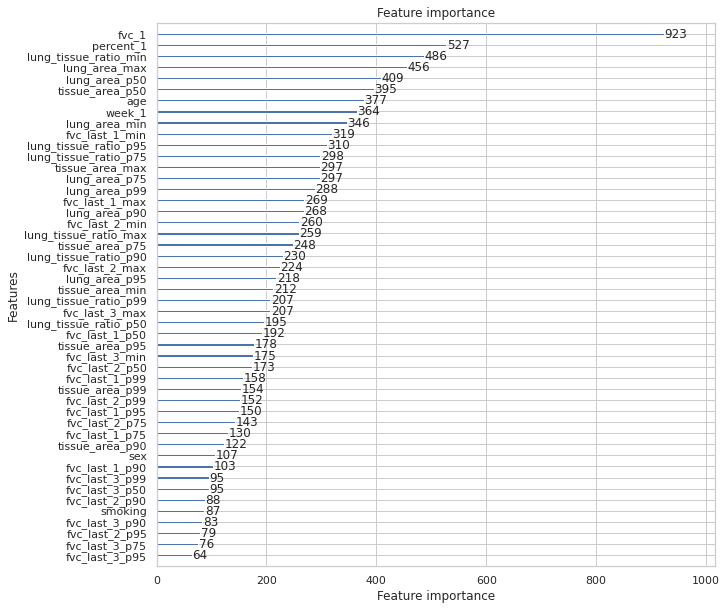

In [65]:
lgb.plot_importance(models[0].best_estimator_['model'], figsize=(10, 10))
    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

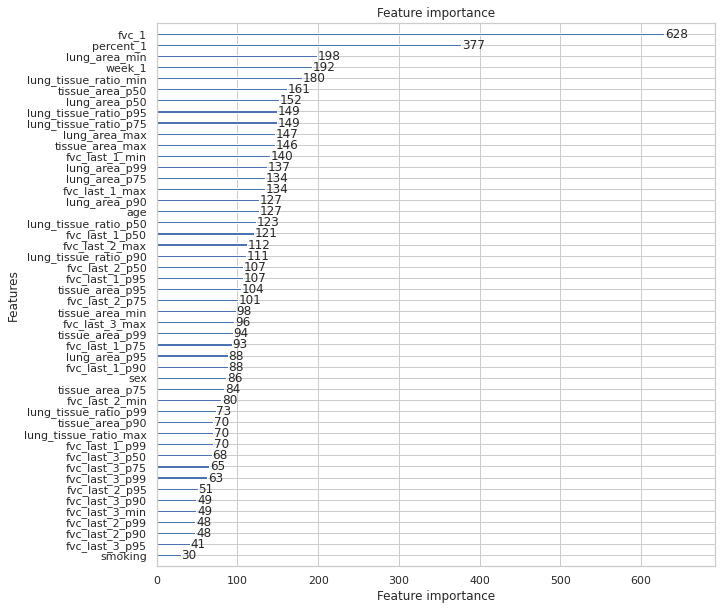

In [66]:
lgb.plot_importance(models[1].best_estimator_['model'], figsize=(10, 10))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

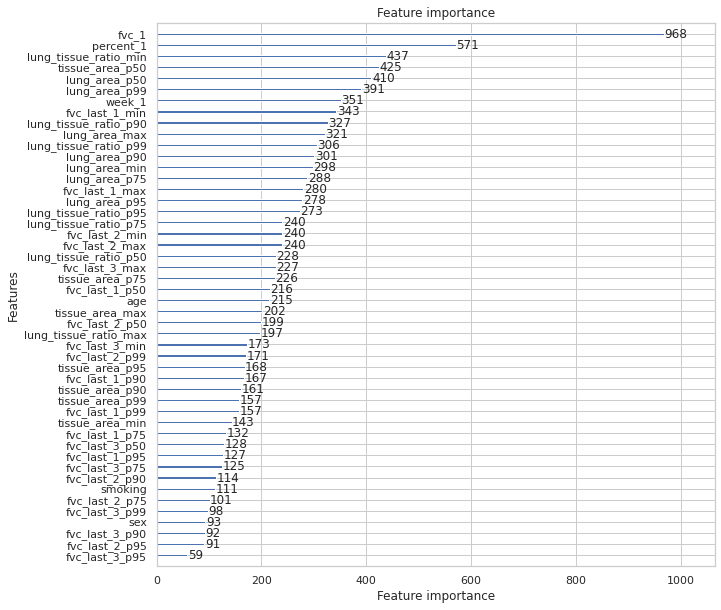

In [67]:
lgb.plot_importance(models[2].best_estimator_['model'], figsize=(10, 10))

In [68]:
for i in range(len(models)):
    y = TARGET[i]
    lgbm = models[i]
    lgbm.best_estimator_['model'].booster_.save_model(f'output/lgb_{y}.txt')